
# A practitioners guide to Floating Point numbers


## 0. Motivational examples

Why one needs to know in details how floating point number are represented in computers.


### (a) Instability of algorithms

Let's consider the integrals 

$$I(n) = \int_0^1 x^n e^{-x} \mathrm{d}x , \quad n = 1, 2, \ldots \tag{1}$$

Since the integrand is positive,

$$I(n) > 0 .$$

Moreover, since $x^{n+1} < x^n$ for $0 < x < 1$,

$$I(n) > I(n+1).$$

We'll use those properties of the integral to check the validity of our numerical calculations.


Integrating by parts, we can establish the following recurrence relation

$$I(n+1) = n I(n) - \frac{1}{e} \tag{2}$$

Also,

$$I(1) = 1 - \frac{2}{e} . \tag{3}$$

We can use recurrence relation (2) together with the initial condition (3) to calculate $I(n)$ for any $n$.

In [1]:

using QuadGK
using PyPlot

In [2]:

integrand(x, n) = x^n * exp(-x)

integrand (generic function with 1 method)

Calculate $I(1)$ as well as estimate the error and count the number of function evaluations:

In [3]:

res = quadgk_count(x -> integrand(x, 1), 0.0, 1.0)

(0.26424111765711533, 0.0, 15)


Check that the integral is evaluated correctly (if not, the error message is printed):

In [4]:

@assert res[1] ≈ 1 - 2*exp(-1) || error("I(1) is wrong")


Calculate I(n) for $n = 1, \ldots, 22)$, store the results and measure the elapsed time:

In [5]:

np = 22
res1 = zeros(np)
res2 = zeros(np);

In [6]:

t_quadgk = @elapsed for n = 1:np
    res1[n] = quadgk(x -> integrand(x, n), 0.0, 1.0)[1]
end

0.188325641

In [7]:

# run this cell twice to exclude the compilation time
res2[1] = 1.0 - 2*exp(-1.0)
t_recur = @elapsed for n = 2:np
    res2[n] = n * res2[n-1] - exp(-1.0)
end

0.004305013


The specialized recursive algorithm runs much faster than generic QuadGK. Speedup:

In [8]:
t_quadgk / t_recur

43.7456613952153

However, ...

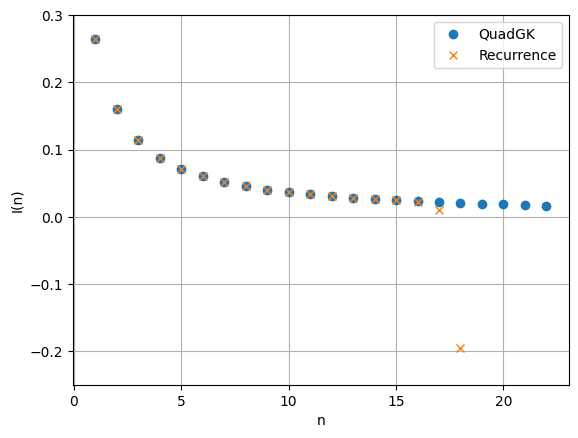

In [9]:

plot(1:np, res1, marker="o", linestyle="none", label="QuadGK")
plot(1:np, res2, marker="x", linestyle="none", label="Recurrence")
ylim(-0.25, 0.3)
legend()
grid(true)
xlabel("n")
ylabel("I(n)");

In [10]:
#] add SpecialFunctions

In [11]:
using SpecialFunctions

function myfactorial(n::Int)
    f = 1.0
    for i = 1:n
        f *= i
    end
    return f
end

myfactorial (generic function with 1 method)

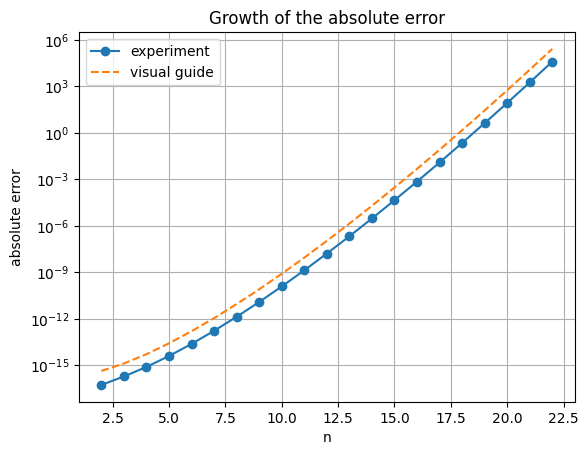

In [12]:

semilogy(2:np, (abs.(res1 .- res2))[2:np], marker="o", label="experiment")
semilogy(2:np, eps() * myfactorial.(2:np), linestyle="dashed", label="visual guide")
grid(true)
legend()
xlabel("n")
ylabel("absolute error")
title("Growth of the absolute error");


### (b) Numerical dertivatives

Finite difference formulas for the first derivative:


Forward difference, error $\sim O(h)$:
$$
f'(x) = \lim_{h \to 0}{\frac{f(x+h) - f(x)}{h}},
\qquad
f'(x) = \frac{f(x+h) - f(x)}{h} + \alpha_1 h + \ldots
$$

Central difference, error $\sim O(h^2)$:
$$
f'(x) = \lim_{h \to 0}{\frac{f(x+h) - f(x-h)}{2h}},
\qquad
f'(x) = \frac{f(x+h) - f(x-h)}{2h} + \alpha_2 h^2 + \ldots
$$

Central difference, error $\sim O(h^4)$:
$$
f'(x) = \lim_{h \to 0}{\frac{-f(x+2h) + 8f(x+h) -8f(x-h) + f(x-2h)}{12h}},
\qquad
f'(x) = \frac{-f(x+2h) + 8f(x+h) -8f(x-h) + f(x-2h)}{12h} + \alpha_4 h^4 + \ldots.
$$


In [13]:

forward(f, x, h) = (f(x + h) - f(x)) / h
central2(f, x, h) = (f(x + h) - f(x - h)) / (2 * h)
central4(f, x, h) = (-f(x + 2 * h) + 8 * f(x + h) - 8 * f(x - h) + f(x - 2 * h)) / (12 * h);


The test function and its analytic derivative:

In [14]:

f(x) = exp(x) + sin(x)
fp(x) = exp(x) + cos(x);

In [15]:

np = 53
dx = 2.0 .^ ((-np):0)
err_f = similar(dx)
err_c2 = similar(dx)
err_c4 = similar(dx);

In [16]:

x0 = 1.0
exact_fpx0 = fp(x0) # exact value of the derivative at x0

for i in 1:(np + 1)
    err_f[i] = abs(forward(f, x0, dx[i]) - exact_fpx0)
    err_c2[i] = abs(central2(f, x0, dx[i]) - exact_fpx0)
    err_c4[i] = abs(central4(f, x0, dx[i]) - exact_fpx0)
end

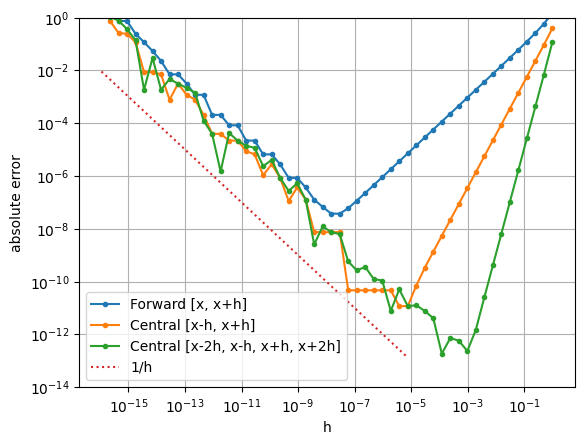

In [17]:

loglog(dx, err_f; marker=".", label="Forward [x, x+h]")
loglog(dx, err_c2; marker=".", label="Central [x-h, x+h]")
loglog(dx, err_c4; marker=".", label="Central [x-2h, x-h, x+h, x+2h]")
loglog(dx[1:37], 1e-18 ./ dx[1:37], linestyle="dotted", label="1/h")
legend()
grid(true)
xlabel("h")
ylabel("absolute error")
ylim(1e-14, 1.0);


### (c) Catastrophic cancellations


Consider the function

$$f(x) = \frac{2}{x^2} \left( \frac{1}{\sqrt{1 - x^2}} - 1\right) $$

$f(x)$ is a well-behaving function as $x \to 0$. For small $x$, $x \ll 1$, 

$$f(x) \approx 1 + \frac{3}{4} x^2 + O(x^4)$$

However, the plot of $f(x)$ looks very different ...

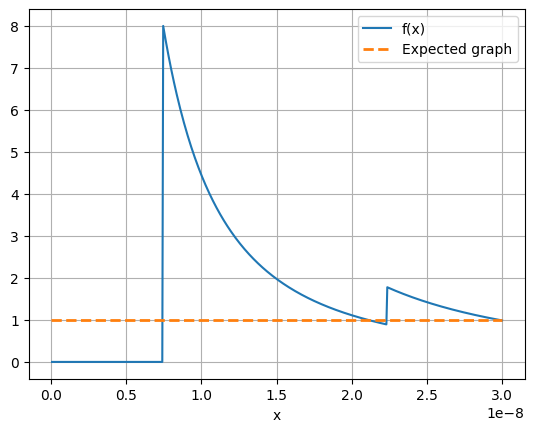

In [18]:

f(x) = 2*(1/sqrt(1-x^2) - 1)/x^2
x = range(0.0, 3e-8, 500)
plot(x, f.(x), label="f(x)")
plot(x, 1 .+ 3/4*x .^2, label="Expected graph", linestyle="dashed", linewidth=2)
legend()
grid(true)
xlabel("x");


## 1. Floating Point representation


#### Decimal floating point numbers


|Scientific notation	|Fixed-point value  | Sign |Significand	|Exponent|
| :-: | :-: | :-: | :-: | -: |
|1.5 ⋅ 10⁴	|15000 | + | 1.5	|4|
|-2.001 ⋅ 10²	|-200.1|- | 2.001	|2	|
|5 ⋅ 10⁻³	|0.005|+| 5	|-3	|
|6.667 ⋅ 10⁻¹¹	|0.00000000006667| + | 6.667	|-11	|


Integer part of a decimal-based significand: $$1 \le [\mathrm{significand}] \le 9, \quad 9 = 10 - 1$$.  


#### Binary floating point numbers


$$(-)1.b_1 b_2 b_3 \ldots b_d = (-1)^s \times \left( 1 + \frac{b_1}{2} + \frac{b_2}{2^2} + \frac{b_3}{2^3} + \ldots + \frac{b_d}{2^d} \right) \times 2^E$$

1. $d$ is fixed, usually by hardware; some or all $b_i$ can be zeros.

1. The integer part of the significand is always 1 ($1 \le [\mathrm{significand}] \le 2-1 = 1$)

1. There is a finite number of binary floating point. There are exactly $2^d$ foating point numbers $x$, $1 \le x <2$ corresponding to $E=0$ in the expression above. The same number of floating points numbers $x$ is for intervals $2 \le x <4$, $\;4 \le x <8$, $\ldots$, $2^k \le x <2^{k+1}$, $k = 0, \pm1, \pm2, \ldots$.

1. The separation between 1.0 and the next binary floating point number is called machine epsilon: $$\epsilon = 2^{-d}$$.

1. If $E_{max}$ is the largest possible value of the Exponent, the largest floating point number is
$$\left( 1 + \frac{1}{2} + \frac{1}{2^2} + \frac{1}{2^3} + \ldots + \frac{1}{2^d} \right) \times 2^{E_{max}} = \left( 2 - \frac{1}{2^{d+1}}  \right) \times 2^{E_{max}} \approx 2^{E_{max} + 1} $$.

Similarly, if $E_{min}$ is the smallest possible value of the Exponent, ($E_{min} < 0$), the smallest positive floating point number is
$$\left( 1 + \frac{0}{2} + \frac{0}{2^2} + \frac{0}{2^3} + \ldots + \frac{1}{2^d} \right) \times 2^{E_{min}} = \left( 1 + \frac{1}{2^{d}}  \right) \times 2^{E_{min}} \approx 2^{E_{min}} $$.


### IEEE (Institute of Electrical and Electronics Engineers) standard for floating point arithmetics:

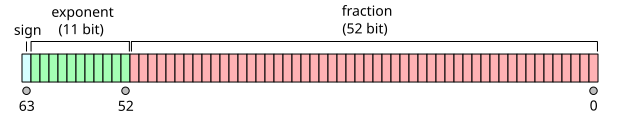


#### The Sign bit

In [19]:

bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [20]:

bitstring(-1.0)

"1011111111110000000000000000000000000000000000000000000000000000"

In [21]:

"""
    floatbits(x)

Produce the text string of binary representation of a floating point number
"""
function floatbits(x::Float64)
    b = bitstring(x)
    b[1:1] * "|" * b[2:12] * "|" * b[13:end]
end

floatbits

In [22]:

floatbits(1.0)

"0|01111111111|0000000000000000000000000000000000000000000000000000"


#### The exponent (powers of 2)

In [23]:

"""
    exponent(x)

Decimal value of the exponent of the binary representation of a floating point number
"""
function exponent(x::Float64)
    parse(Int, bitstring(x)[2:12], base=2)
end

exponent

In [24]:

floatbits(1.0)

"0|01111111111|0000000000000000000000000000000000000000000000000000"

In [25]:

exponent(1.0)

1023


#### Significand

The Signifcand stored as 52 bits, and is interpreted as *1.b₁b₂…b₅₂* i.e. 
$$1 + \frac{b_1}{2} + \frac{b_2}{4} + \frac{b_3}{8} + \ldots + \frac{b_n}{2^n} + \ldots + \frac{b_{52}}{2^{52}}$$

In [26]:

floatbits(1.0)

"0|01111111111|0000000000000000000000000000000000000000000000000000"

In [27]:

1 * 2^(1023-1023)

1

In [28]:

floatbits(1.5)

"0|01111111111|1000000000000000000000000000000000000000000000000000"

In [29]:

(1 + 1/2) * 2 ^ (1023-1023)

1.5

In [30]:

floatbits(1.75)

"0|01111111111|1100000000000000000000000000000000000000000000000000"

In [31]:

(1 + 1/2 + 1/2^2) * 2 ^ (1023-1023)

1.75

In [32]:

floatbits(15.0)

"0|10000000010|1110000000000000000000000000000000000000000000000000"

In [33]:

exponent(15.0)

1026

In [34]:

(1 + 1/2 + 1/4 + 1/8)

1.875

In [35]:

1.875 * 2^(1026-1023)

15.0


### Approximate representation

Not all decimal numbers are exactly representable as binary floating point number. 
Therefore, many decimal values can be approximated by the same floating number. 

In [36]:

0.1 > 1//10

true

In [37]:

floatbits(0.1)

"0|01111111011|1001100110011001100110011001100110011001100110011010"

In [38]:

floatbits(0.10000000000000001)

"0|01111111011|1001100110011001100110011001100110011001100110011010"

In [39]:

bitstring(0.10000000000000001) == bitstring(0.1)

true

### Machine epsilon

In [40]:

eps(0.1)

1.3877787807814457e-17

In [41]:

nextfloat(0.1)

0.10000000000000002

In [42]:

floatbits(nextfloat(0.1))

"0|01111111011|1001100110011001100110011001100110011001100110011011"

In [43]:

nextfloat(0.1) - 0.1 == eps(0.1)

true

## 2. Special Forms

#### Signed Zeros

In [44]:

floatbits(0.0)

"0|00000000000|0000000000000000000000000000000000000000000000000000"

In [45]:

floatbits(-0.0)

"1|00000000000|0000000000000000000000000000000000000000000000000000"

In [46]:

0.0 == -0.0

true

In [47]:

0.0 === -0.0

false


#### Infinity

is represented with an exponent of all ones, and signicand of all zeros

In [48]:

floatbits(Inf)

"0|11111111111|0000000000000000000000000000000000000000000000000000"

In [49]:

floatbits(-Inf)

"1|11111111111|0000000000000000000000000000000000000000000000000000"


#### Not A Number (NaN)

is represented with an exponent of all ones, and a non zero significand

In [50]:

floatbits(NaN)

"0|11111111111|1000000000000000000000000000000000000000000000000000"

In [51]:

NaN == NaN

false

In [52]:

NaN === NaN

true

In [53]:

0/0

NaN

In [54]:

0/0 == 0/0

false

In [55]:

1.5/0

Inf

## 3. Rounding

In [56]:

0.1 + 0.2

0.30000000000000004

In [57]:

big(0.1) + big(0.2)

0.3000000000000000166533453693773481063544750213623046875

In [58]:

0.1 + 0.2 - (big(0.1) + big(0.2))  < 2 * eps(0.3)

true

In [59]:

eps(0.3)

5.551115123125783e-17

Floating point operations are not associative

In [60]:

(0.1 + 0.2) + 0.3

0.6000000000000001

In [61]:

0.1 + (0.2 + 0.3)

0.6

In [62]:

sum([1.0, 10e100, 1.0, -10e100])

0.0

In [63]:

1.0 + 10e100 + 1.0 +  -10e100

0.0

In [64]:

10e100  + -10e100 + 1.0 + 1.0

2.0

In [84]:
#] add KahanSummation

   Resolving package versions...
   Installed KahanSummation ─ v0.3.1
    Updating `/workspaces/phys2200-lectures-tec22001/Project.toml`
  [8e2b3108] + KahanSummation v0.3.1
    Updating `/workspaces/phys2200-lectures-tec22001/Manifest.toml`
  [8e2b3108] + KahanSummation v0.3.1
Precompiling project...
   7595.7 ms  ✓ KahanSummation
  1 dependency successfully precompiled in 15 seconds. 164 already precompiled.


In [85]:

using KahanSummation

In [86]:

sum_kbn([1.0, 10e100, 1.0, -10e100])

2.0

### Cancellation


Errors can blow up when subtracting two numbers that are close together. 
Consider the following function:

$$f(x) = \frac{1 - \cos(x)}{x^2}, \qquad 0 \le f(x) \le \frac{1}{2} . $$

In [67]:

f(x) = (1 - cos(x))/x^2

f (generic function with 1 method)

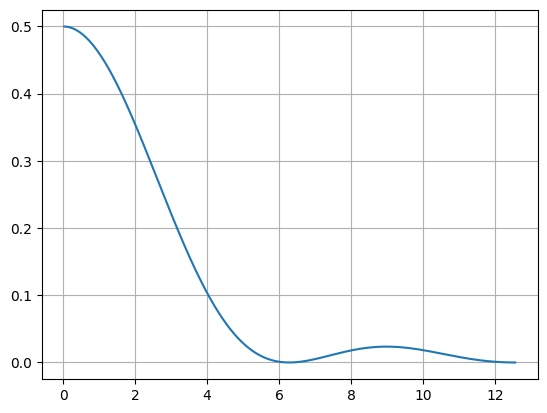

In [68]:

x = range(0.0, 4*pi, 500)[2:end]
plot(x, f.(x))
grid(true)

In [69]:

f(1.2e-8)

0.7709882115452477

In [70]:

cos(1.2e-8)

0.9999999999999999

In [71]:

1-0.9999999999999999

1.1102230246251565e-16

In [72]:

1.1102230246251565e-16 / 1.44e-16

0.7709882115452477

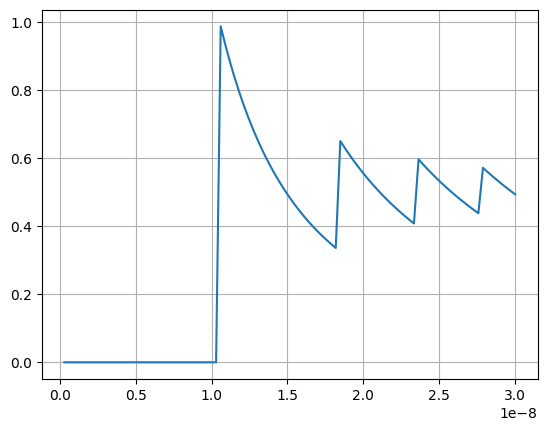

In [73]:

x = range(0.0, 3e-8, 100)[2:end]
plot(x, f.(x))
grid(true)

Fixed by rewriting to equivalent form, without subtraction

$$f(x) = \frac{1 - \cos(x)}{x^2} = \frac{2 \sin^2(x/2)}{x^2} = \frac{1}{2} \left(\frac{\sin(x/2)}{x/2} \right)^2 . $$

In [74]:

f2(x) = 0.5 * (sin(x/2) / (x/2))^2

f2 (generic function with 1 method)

In [75]:

f2(1.2e-8)

0.5

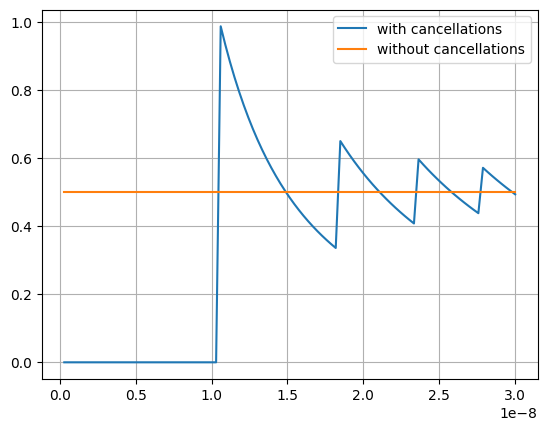

In [76]:

x = range(0.0, 3e-8, 100)[2:end]
plot(x, f.(x), label="with cancellations")
plot(x, f2.(x), label="without cancellations")
legend()
grid(true)

### Special Functions

In [77]:

sin(π)

0.0

In [78]:

sin(100_000_000π)

-3.9082928156687315e-8

In [79]:

sinpi(100_000_000)

0.0

In [80]:

cospi(1000000000000000)

1.0

In [81]:

cos(1000000000000000pi)

0.9717022605520254


$$\exp(x) = \sum_{n=0}^\infty \frac{x^n}{n!} = 1 + x + \frac12 x^2 + \dots$$
Therefore, for $x \ll 1$, we have $\exp(x) \approx 1 + x$ \
Hence cancellation can occur when calculating $\exp(x) -1$, for $x \ll 1$

In [82]:

exp(1e-13) - 1.0

9.992007221626409e-14

In [83]:

expm1(1e-13)

1.00000000000005e-13


## 4. More information

  * Nicholas J Higham , *The Accuracy and Stability of Numerical Algorithms*,
    2nd Edition, 2002

  * Avik Sengupta, "Everything you wanted to know about Floating Point numbers", <a href="https://youtu.be/x3qBNuWluMY?t=73">Video of the talk</a>
